<a href="https://colab.research.google.com/github/Ziqi-Li/GEO4162C/blob/main/notebooks/Network_Analysis_10_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Analysis

- Travelling Salesman Problem
- Road network
- Centrality

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a complete graph with 6 nodes and random edge weights
G = nx.Graph()

G.add_edge('A', 'B', weight=4)
G.add_edge('B', 'C', weight=8)
G.add_edge('C', 'A', weight=7)
G.add_edge('A', 'D', weight=3)
G.add_edge('D', 'C', weight=5)
G.add_edge('D', 'B', weight=2)
G.add_edge('E', 'C', weight=8)
G.add_edge('D', 'E', weight=5)

## Draw a graph G

To draw the graph, you need to define the positions of the nodes, or your can use some pre-defined layouts such as the `shell_layout` (concentric circles)here.

If working with real world data, we can use the geographic coordinates.

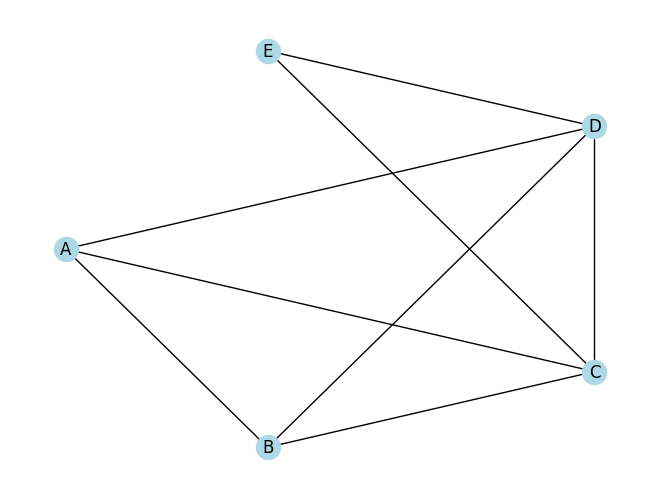

In [2]:
#define position
pos = nx.shell_layout(G)

nx.draw(G, pos, with_labels=True, node_color='lightblue')

## Add weights to the edges

{('A', 'B'): Text(-0.6545085608959198, -0.4755282839152457, '4'),
 ('A', 'C'): Text(-0.09549137949943542, -0.2938925166937949, '7'),
 ('A', 'D'): Text(-0.09549149870872498, 0.29389257828263027, '3'),
 ('B', 'C'): Text(0.2500000596046448, -0.769420713186264, '8'),
 ('B', 'D'): Text(0.24999994039535522, -0.18163561820983887, '2'),
 ('C', 'D'): Text(0.8090171217918396, 1.4901161193847656e-07, '5'),
 ('C', 'E'): Text(0.24999991059303284, 0.18163570761680603, '8'),
 ('D', 'E'): Text(0.2499997913837433, 0.7694208025932312, '5')}

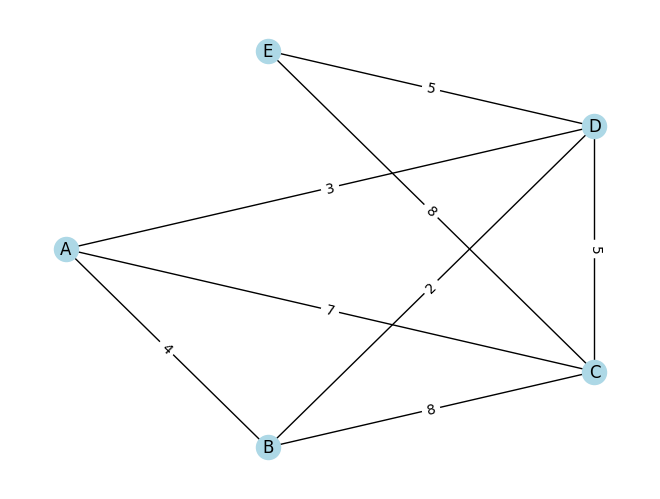

In [3]:
nx.draw(G, pos, with_labels=True, node_color='lightblue')


edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


## TSP

Here I define a helper function `tsp` which only takes one parameter Graph G.

In [4]:
def tsp(G):
  # Calculate an approximate TSP solution
  approx_tour = nx.approximation.traveling_salesman_problem(G, cycle=True)

  # Calculate the length of the approximate tour
  approx_tour_length = sum(G[u][v]['weight'] for u, v in zip(approx_tour, approx_tour[1:]))

  #Draw Graph
  nx.draw(G, pos, with_labels=True, node_color='lightblue')

  #Draw TSP path
  nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in zip(approx_tour, approx_tour[1:] + [approx_tour[0]])], edge_color='red', width=4)

  #Add Lavels to Edges
  edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  # Print the results
  plt.title(f'Approximate TSP Tour (Length: {approx_tour_length})')



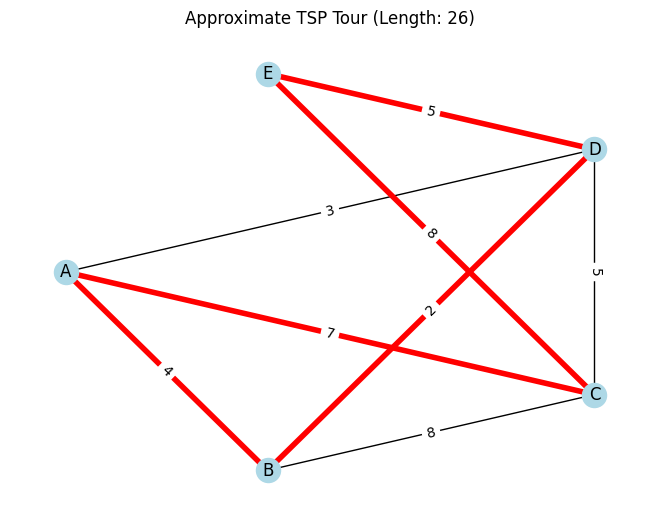

In [5]:
tsp(G)

# Road network analysis

Here we will be using a package called `osmnx`, which can fetch Open Street Map data and put them into a clean network format.

Reference: https://osmnx.readthedocs.io/en/stable/user-reference.html

In [6]:
pip install -q osmnx

In [7]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

You can fetch data for any city/place in the world. There are also different types of network: drive, bike, walk, etc.
Custom filter can be specified, and keywords can be found here: https://wiki.openstreetmap.org/wiki/Map_features

In [21]:
G_tally = ox.graph_from_place('Tallahassee, Florida, USA', network_type='drive')

#G_tally = ox.graph_from_place('Tallahassee, Florida, USA', network_type='drive', custom_filter='["highway"~"primary"]'))

Plot the network, you can modify the color, node size, map size, etc.

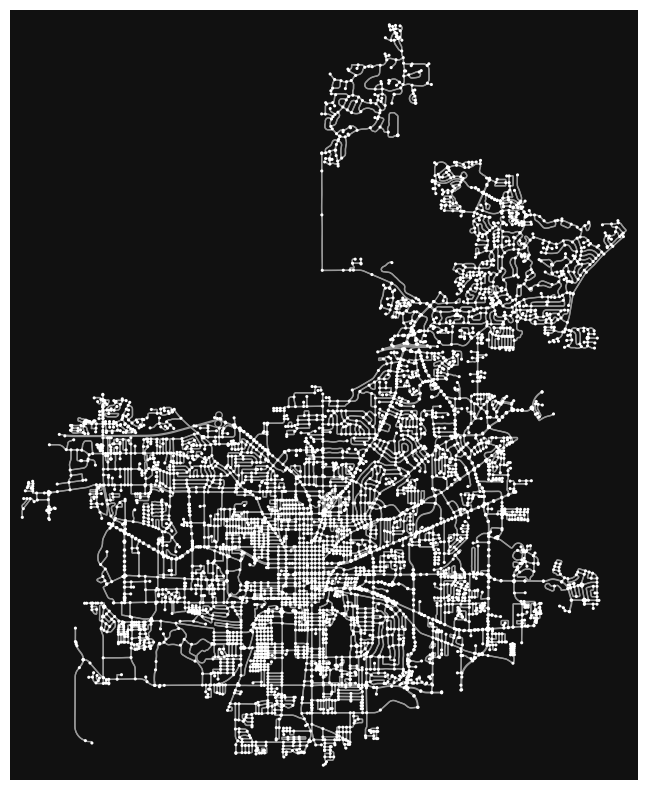

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [22]:
ox.plot_graph(G_tally,node_size=5,figsize=(10,10)) #Plotting a network

# Calculate centrality measures

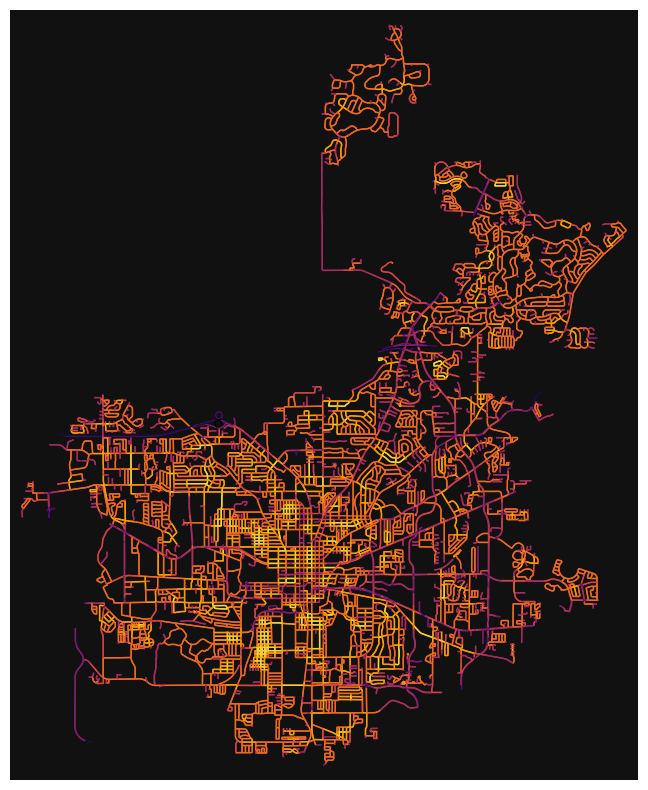

In [10]:
degree_centrality = nx.degree_centrality(nx.line_graph(G_tally))

nx.set_edge_attributes(G_tally, degree_centrality, 'degree_centrality')

ec = ox.plot.get_edge_colors_by_attr(G_tally, 'degree_centrality', cmap='inferno')

fig, ax = ox.plot_graph(G_tally, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(10,10))

Lighter yellow areas are places/nodes with higher degree centrality.

## Betweenness centrality

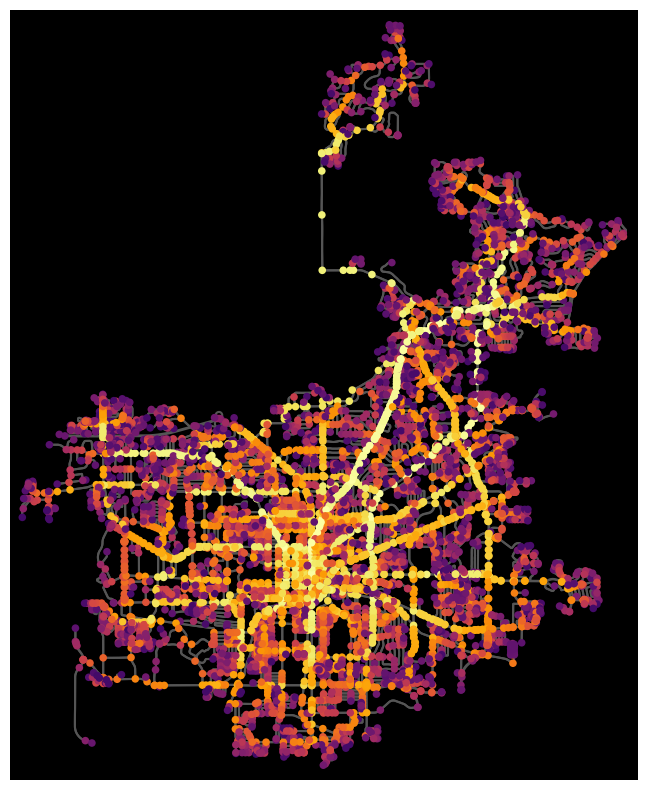

CPU times: user 8min 34s, sys: 1.37 s, total: 8min 35s
Wall time: 8min 45s


In [11]:
%%time
bt_centrality = nx.betweenness_centrality(nx.DiGraph(G_tally),weight="length")

df = pd.DataFrame(data=pd.Series(bt_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G_tally.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G_tally, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1, figsize=(10,10))

Lighter yellow areas are places/nodes with higher betweenness centrality.

In [12]:
#Origin and Destination coordinates
#Replace these with your own origin or destination
origin = (30.44358541934727, -84.29576058983379)
destination = (30.489547200638935, -84.2493978898358)


In [13]:
#We need to snap them to the nearest node before calculating the path.
origin_node = ox.distance.nearest_nodes(G_tally, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G_tally, destination[1], destination[0])

## Dijkstra algorithm for shortest path

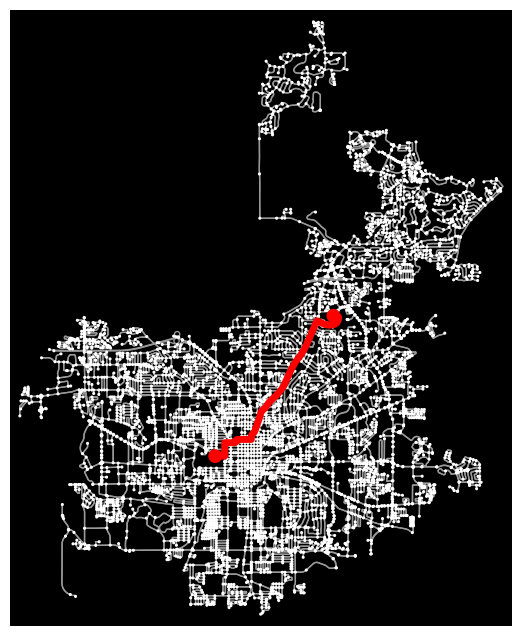

In [14]:
dijstra_route = nx.dijkstra_path(G_tally, origin_node, destination_node, weight="length")


fig, ax = ox.plot_graph_route(G_tally, dijstra_route, route_linewidth=5,
                              node_size=5, bgcolor='k', route_alpha=1)

The total length (in meters)

In [15]:
dijstra_route_length = nx.dijkstra_path_length(G_tally, origin_node, destination_node, weight="length")
dijstra_route_length

8329.539999999999

## How about A* algorithm?

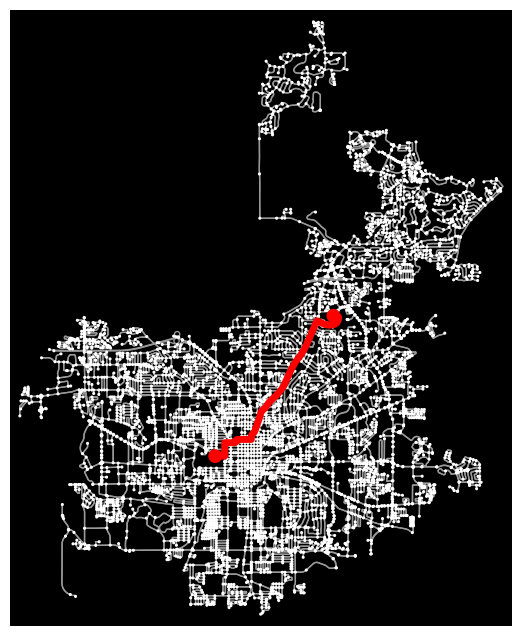

In [16]:
a_star_route = nx.astar_path(G_tally, origin_node, destination_node, weight="length")

fig, ax = ox.plot_graph_route(G_tally, a_star_route, route_linewidth=5, node_size=5, bgcolor='k', route_alpha=1)

The total length

In [17]:
A_star_route_length = nx.astar_path_length(G_tally, origin_node, destination_node, weight="length")

A_star_route_length

8329.539999999999